In [7]:
import os,sys,inspect
import os
import joblib
import tensorflow.compat.v1 as tf
import numpy as np
import h5py
import scipy.sparse.linalg as la
import scipy.sparse as sp
import scipy
import time
from sklearn.neighbors import kneighbors_graph

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

In [8]:
#Flixster
path_dataset = '/Users/liujiaoyang/tensorflow/MGCNN/Data/Flixster/Flixster.mat'
path_implicit = '/Users/liujiaoyang/tensorflow/MGCNN/Data/Flixster/S_implicit.mat'

In [10]:
# auxiliary functions:

# import matlab files in python
def load_matlab_file(path_file, name_field):
    """
    load '.mat' files
    inputs:
        path_file, string containing the file path
        name_field, string containig the field name (default='shape')
    warning:
        '.mat' files should be saved in the '-v7.3' format
    """
    db = h5py.File(path_file, 'r')
    ds = db[name_field]
    try:
        if 'ir' in ds.keys():
            data = np.asarray(ds['data'])
            ir   = np.asarray(ds['ir'])
            jc   = np.asarray(ds['jc'])
            out  = sp.csc_matrix((data, ir, jc)).astype(np.float32)
    except AttributeError:
        # Transpose in case is a dense matrix because of the row- vs column- major ordering between python and matlab
        out = np.asarray(ds).astype(np.float32).T

    db.close()

    return out

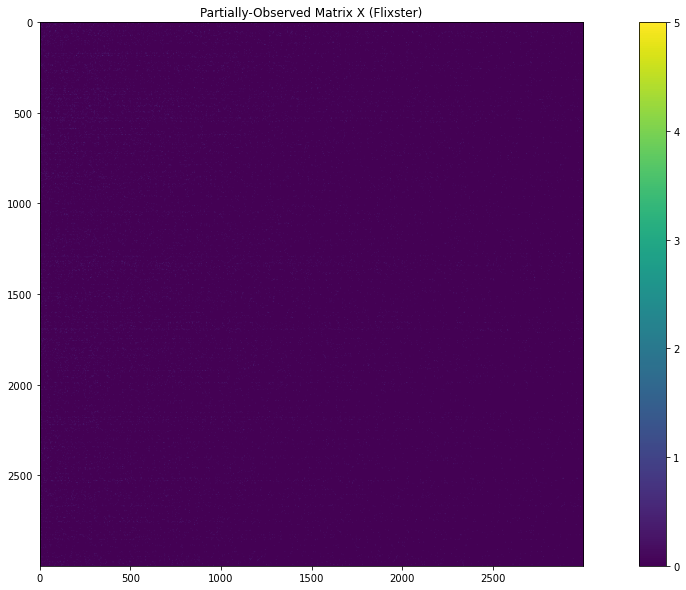

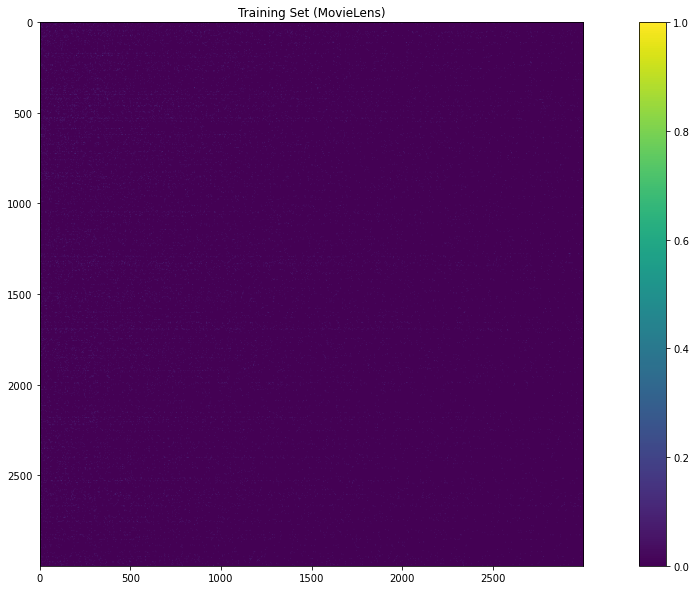

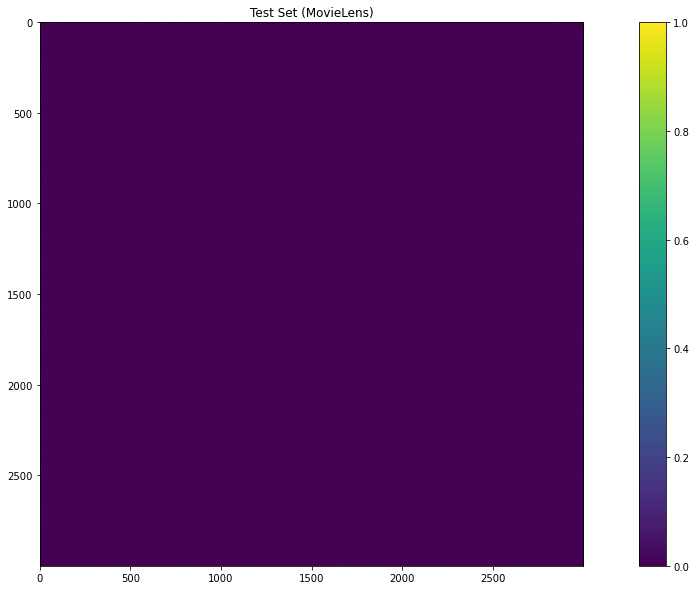

In [11]:
#loading of the required matrices
M = load_matlab_file(path_dataset, 'M')
Otraining = load_matlab_file(path_dataset, 'Otraining')
Otest = load_matlab_file(path_dataset, 'Otest')
Wrow = load_matlab_file(path_dataset, 'W_users') #dense
Wcol = load_matlab_file(path_dataset, 'W_movies') #dense
Su_imp = load_matlab_file(path_implicit, 'Su_imp')
Sb_imp = load_matlab_file(path_implicit, 'Sb_imp')

plt.figure(figsize=(20,10))
plt.imshow(M)
plt.title('Partially-Observed Matrix X (Flixster)')
plt.colorbar()

plt.figure(figsize=(20,10))
plt.imshow(Otraining)
plt.title('Training Set (Flixster)')
plt.colorbar()

plt.figure(figsize=(20,10))
plt.imshow(Otest)
plt.title('Test Set (Flixster)')
plt.colorbar()

In [12]:
# extract implicit features
user_impGraph = kneighbors_graph(Su_imp, 10)
item_impGraph = kneighbors_graph(Sb_imp, 10)

# save sparse matrix
sp.save_npz('user_impGraph.npz', user_impGraph, False)
sp.save_npz('item_impGraph.npz', item_impGraph, False)

# print
print(user_impGraph.shape)
print(item_impGraph.shape)
print(Wrow.shape)
print(Wcol.shape)

(3000, 3000)
(3000, 3000)
(3000, 3000)
(3000, 3000)


In [13]:
# combine explicit and implicit graphs
Wrow = 0.8 * Wrow + 0.2 * user_impGraph
Wcol = 0.8 * Wcol + 0.2 * item_impGraph

In [14]:
np.random.seed(0)
pos_tr_samples = np.where(Otraining)

num_tr_samples = len(pos_tr_samples[0])
list_idx = list(range(num_tr_samples))
np.random.shuffle(list_idx)
idx_data = list_idx[:num_tr_samples//2]
idx_train = list_idx[num_tr_samples//2:]

pos_data_samples = (pos_tr_samples[0][idx_data], pos_tr_samples[1][idx_data])
pos_tr_samples = (pos_tr_samples[0][idx_train], pos_tr_samples[1][idx_train])

Odata = np.zeros(M.shape)
Otraining = np.zeros(M.shape)

for k in range(len(pos_data_samples[0])):
    Odata[pos_data_samples[0][k], pos_data_samples[1][k]] = 1
    
for k in range(len(pos_tr_samples[0])):
    Otraining[pos_tr_samples[0][k], pos_tr_samples[1][k]] = 1
    
print ('Num data samples: %d' % (np.sum(Odata),))
print ('Num train samples: %d' % (np.sum(Otraining),))
print ('Num train+data samples: %d' % (np.sum(Odata+Otraining),))

Num data samples: 11778
Num train samples: 11778
Num train+data samples: 23556


In [15]:
#computation of the normalized laplacians
Lrow = sp.csgraph.laplacian(Wrow, normed=True) 
Lcol = sp.csgraph.laplacian(Wcol, normed=True) 

In [23]:
#apply SVD initially for detecting the main components of our initialization
U, s, V = np.linalg.svd(Odata*M, full_matrices=0)

print (U.shape)
print (s.shape)
print (V.shape)

(3000, 3000)
(3000,)
(3000, 3000)


(3000, 10)
(3000, 10)


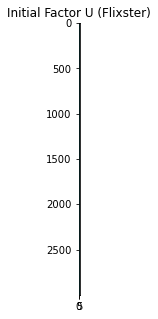

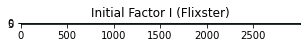

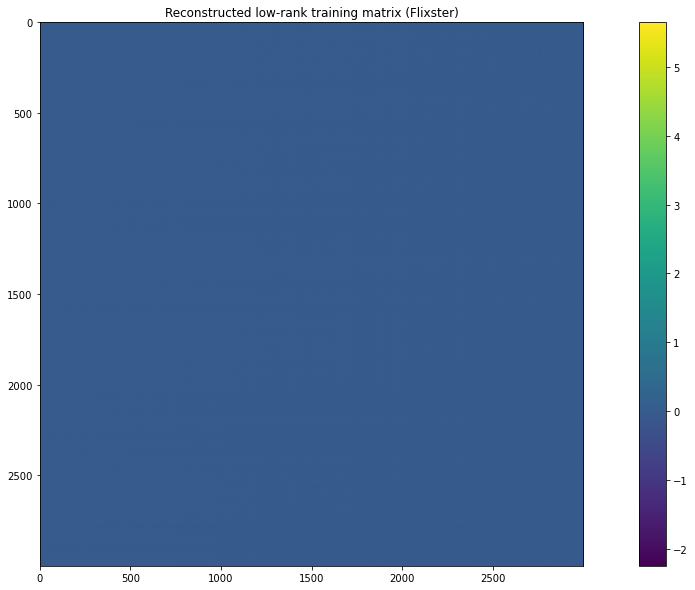

In [24]:
rank_W_H = 10
partial_s = s[:rank_W_H]
partial_S_sqrt = np.diag(np.sqrt(partial_s))
initial_W = np.dot(U[:, :rank_W_H], partial_S_sqrt)
initial_H = np.dot(partial_S_sqrt, V[:rank_W_H, :]).T

print (initial_W.shape)
print (initial_H.shape)

plt.figure(figsize=(20,5))
plt.imshow(initial_W)
plt.title('Initial Factor U (Flixster)')


plt.figure(figsize=(5,20))
plt.imshow(initial_H.T)
plt.title('Initial Factor I (Flixster)')


plt.figure(figsize=(20,10))
plt.imshow(np.dot(initial_W, initial_H.T))
plt.title('Reconstructed low-rank training matrix (Flixster)')
plt.colorbar()

Original training matrix
Reconstructed training matrix


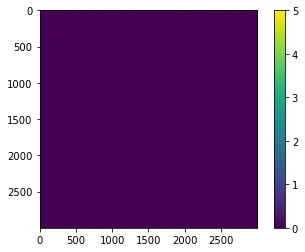

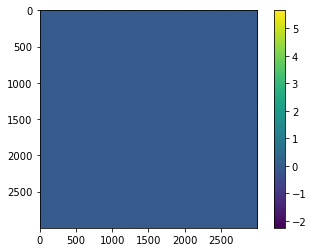

In [25]:
print ('Original training matrix')
plt.figure()
plt.imshow(Odata*M)
plt.colorbar()

print ('Reconstructed training matrix')
plt.figure()
plt.imshow(np.dot(initial_W, initial_H.T))
plt.colorbar()

In [26]:
class Train_test_matrix_completion:
    
    """
    The neural network model.
    """
    
    def frobenius_norm(self, tensor):
        square_tensor = tf.square(tensor)
        tensor_sum = tf.reduce_sum(square_tensor)
        frobenius_norm = tf.sqrt(tensor_sum)
        return frobenius_norm
    
    def mono_conv(self, list_lap, ord_conv, A, W, b):
        
        feat = []
        #collect features
        for k in range(ord_conv):
            c_lap = list_lap[k] 
                                                     
            #dense implementation
            c_feat = tf.matmul(c_lap, A, a_is_sparse=False)
            feat.append(c_feat)
            
        all_feat = tf.concat(feat, 1)
        conv_feat = tf.matmul(all_feat, W) + b
        conv_feat = tf.nn.relu(conv_feat)
        
        return conv_feat
                
    def compute_cheb_polynomials(self, L, ord_cheb, list_cheb):
        for k in range(ord_cheb):
            if (k==0):
                list_cheb.append(tf.cast(tf.diag(tf.ones([tf.shape(L)[0],])), 'float32'))
            elif (k==1):
                list_cheb.append(tf.cast(L, 'float32'))
            else:
                list_cheb.append(2*tf.matmul(L, list_cheb[k-1])  - list_cheb[k-2])
                
    def __init__(self, M, Lr, Lc, Odata, Otraining, Otest, initial_W, initial_H,
                 order_chebyshev_col = 5, order_chebyshev_row = 5,
                 num_iterations = 10, gamma=1.0, learning_rate=1e-4, idx_gpu = '/gpu:3'):
        
        #order of the spectral filters
        self.ord_col = order_chebyshev_col 
        self.ord_row = order_chebyshev_row
        self.num_iterations = num_iterations
        self.n_conv_feat = 32
        
        with tf.Graph().as_default() as g:
                tf.logging.set_verbosity(tf.logging.ERROR)
                self.graph = g
                tf.set_random_seed(0)
                with tf.device(idx_gpu):
                    
                        #loading of the laplacians
                        self.Lr = tf.constant(Lr.astype('float32'))
                        self.Lc = tf.constant(Lc.astype('float32'))
                        
                        self.norm_Lr = self.Lr - tf.diag(tf.ones([Lr.shape[0], ]))
                        self.norm_Lc = self.Lc - tf.diag(tf.ones([Lc.shape[0], ]))
                        
                        #compute all chebyshev polynomials a priori
                        self.list_row_cheb_pol = list()
                        self.compute_cheb_polynomials(self.norm_Lr, self.ord_row, self.list_row_cheb_pol)
                        self.list_col_cheb_pol = list()
                        self.compute_cheb_polynomials(self.norm_Lc, self.ord_col, self.list_col_cheb_pol)
                        
                        #definition of constant matrices
                        self.M = tf.constant(M, dtype=tf.float32)
                        self.Odata = tf.constant(Odata, dtype=tf.float32)
                        self.Otraining = tf.constant(Otraining, dtype=tf.float32) #training mask
                        self.Otest = tf.constant(Otest, dtype=tf.float32) #test mask
                         
                        ##################################definition of the NN variables#####################################
                        
                        #definition of the weights for extracting the global features
                        self.W_conv_W = tf.get_variable("W_conv_W", shape=[self.ord_col*initial_W.shape[1], self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.b_conv_W = tf.Variable(tf.zeros([self.n_conv_feat,]))
                        self.W_conv_H = tf.get_variable("W_conv_H", shape=[self.ord_row*initial_W.shape[1], self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.b_conv_H = tf.Variable(tf.zeros([self.n_conv_feat,]))
                        
                        #recurrent N parameters
                        self.W_f_u = tf.get_variable("W_f_u", shape=[self.n_conv_feat, self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.W_i_u = tf.get_variable("W_i_u", shape=[self.n_conv_feat, self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.W_o_u = tf.get_variable("W_o_u", shape=[self.n_conv_feat, self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.W_c_u = tf.get_variable("W_c_u", shape=[self.n_conv_feat, self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.U_f_u = tf.get_variable("U_f_u", shape=[self.n_conv_feat, self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.U_i_u = tf.get_variable("U_i_u", shape=[self.n_conv_feat, self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.U_o_u = tf.get_variable("U_o_u", shape=[self.n_conv_feat, self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.U_c_u = tf.get_variable("U_c_u", shape=[self.n_conv_feat, self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.b_f_u = tf.Variable(tf.zeros([self.n_conv_feat,]))
                        self.b_i_u = tf.Variable(tf.zeros([self.n_conv_feat,]))
                        self.b_o_u = tf.Variable(tf.zeros([self.n_conv_feat,]))
                        self.b_c_u = tf.Variable(tf.zeros([self.n_conv_feat,]))
                        
                        self.W_f_m = tf.get_variable("W_f_m", shape=[self.n_conv_feat, self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.W_i_m = tf.get_variable("W_i_m", shape=[self.n_conv_feat, self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.W_o_m = tf.get_variable("W_o_m", shape=[self.n_conv_feat, self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.W_c_m = tf.get_variable("W_c_m", shape=[self.n_conv_feat, self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.U_f_m = tf.get_variable("U_f_m", shape=[self.n_conv_feat, self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.U_i_m = tf.get_variable("U_i_m", shape=[self.n_conv_feat, self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.U_o_m = tf.get_variable("U_o_m", shape=[self.n_conv_feat, self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.U_c_m = tf.get_variable("U_c_m", shape=[self.n_conv_feat, self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.b_f_m = tf.Variable(tf.zeros([self.n_conv_feat,]))
                        self.b_i_m = tf.Variable(tf.zeros([self.n_conv_feat,]))
                        self.b_o_m = tf.Variable(tf.zeros([self.n_conv_feat,]))
                        self.b_c_m = tf.Variable(tf.zeros([self.n_conv_feat,]))
                        
                        #output parameters
                        self.W_out_W = tf.get_variable("W_out_W", shape=[self.n_conv_feat, initial_W.shape[1]], initializer=tf.glorot_uniform_initializer()) 
                        self.b_out_W = tf.Variable(tf.zeros([initial_W.shape[1],]))
                        self.W_out_H = tf.get_variable("W_out_H", shape=[self.n_conv_feat, initial_H.shape[1]], initializer=tf.glorot_uniform_initializer()) 
                        self.b_out_H = tf.Variable(tf.zeros([initial_H.shape[1],]))
                        
                        #########definition of the NN
                        #definition of W and H
                        self.W = tf.constant(initial_W.astype('float32'))
                        self.H = tf.constant(initial_H.astype('float32'))
                        
                        self.X = tf.matmul(self.W, self.H, transpose_b=True) #we may initialize it at random here
                        self.list_X = list()
                        self.list_X.append(tf.identity(self.X))
                        
                        #RNN
                        self.h_u = tf.zeros([M.shape[0], self.n_conv_feat])
                        self.c_u = tf.zeros([M.shape[0], self.n_conv_feat])
                        self.h_m = tf.zeros([M.shape[1], self.n_conv_feat])
                        self.c_m = tf.zeros([M.shape[1], self.n_conv_feat])
                        
                        
                        for k in range(self.num_iterations):
                            #extraction of global features vectors
                            self.final_feat_users = self.mono_conv(self.list_row_cheb_pol, self.ord_row, self.W, self.W_conv_W, self.b_conv_W)
                            self.final_feat_movies = self.mono_conv(self.list_col_cheb_pol, self.ord_col, self.H, self.W_conv_H, self.b_conv_H)
                            
                            #here we have to split the features between users and movies LSTMs
                            
                            #users RNN
                            self.f_u = tf.sigmoid(tf.matmul(self.final_feat_users, self.W_f_u) + tf.matmul(self.h_u, self.U_f_u) + self.b_f_u)
                            self.i_u = tf.sigmoid(tf.matmul(self.final_feat_users, self.W_i_u) + tf.matmul(self.h_u, self.U_i_u) + self.b_i_u)
                            self.o_u = tf.sigmoid(tf.matmul(self.final_feat_users, self.W_o_u) + tf.matmul(self.h_u, self.U_o_u) + self.b_o_u)
                            
                            self.update_c_u = tf.sigmoid(tf.matmul(self.final_feat_users, self.W_c_u) + tf.matmul(self.h_u, self.U_c_u) + self.b_c_u)
                            self.c_u = tf.multiply(self.f_u, self.c_u) + tf.multiply(self.i_u, self.update_c_u)
                            self.h_u = tf.multiply(self.o_u, tf.sigmoid(self.c_u))
                            
                            #movies RNN
                            self.f_m = tf.sigmoid(tf.matmul(self.final_feat_movies, self.W_f_m) + tf.matmul(self.h_m, self.U_f_m) + self.b_f_m)
                            self.i_m = tf.sigmoid(tf.matmul(self.final_feat_movies, self.W_i_m) + tf.matmul(self.h_m, self.U_i_m) + self.b_i_m)
                            self.o_m = tf.sigmoid(tf.matmul(self.final_feat_movies, self.W_o_m) + tf.matmul(self.h_m, self.U_o_m) + self.b_o_m)
                            
                            self.update_c_m = tf.sigmoid(tf.matmul(self.final_feat_movies, self.W_c_m) + tf.matmul(self.h_m, self.U_c_m) + self.b_c_m)
                            self.c_m = tf.multiply(self.f_m, self.c_m) + tf.multiply(self.i_m, self.update_c_m)
                            self.h_m = tf.multiply(self.o_m, tf.sigmoid(self.c_m))
                            
                            #compute update of matrix X
                            self.delta_W = tf.tanh(tf.matmul(self.c_u, self.W_out_W) + self.b_out_W) #N x rank_W_H
                            self.delta_H = tf.tanh(tf.matmul(self.c_m, self.W_out_H) + self.b_out_H) #M x rank_W_H
                            
                            self.W += self.delta_W
                            self.H += self.delta_H
                        
                            self.X = tf.matmul(self.W, self.H, transpose_b=True)
                            self.list_X.append(tf.identity(tf.reshape(self.X, [tf.shape(self.M)[0], tf.shape(self.M)[1]])))
                        self.X = tf.matmul(self.W, self.H, transpose_b=True)
                        #########loss definition
                        
                        #computation of the accuracy term
                        self.norm_X = 0.5+4.5*(self.X-tf.reduce_min(self.X))/(tf.reduce_max(self.X-tf.reduce_min(self.X)))
                        frob_tensor = tf.multiply(self.Otraining + self.Odata, self.norm_X - M)
                        self.loss_frob = tf.square(self.frobenius_norm(frob_tensor))/np.sum(Otraining+Odata)
                        
                        #computation of the regularization terms
                        trace_col_tensor = tf.matmul(tf.matmul(self.X, self.Lc), self.X, transpose_b=True)
                        self.loss_trace_col = tf.trace(trace_col_tensor)
                        trace_row_tensor = tf.matmul(tf.matmul(self.X, self.Lr, transpose_a=True), self.X)
                        self.loss_trace_row = tf.trace(trace_row_tensor)
                        
                        #training loss definition
                        self.loss = self.loss_frob + (gamma/2)*(self.loss_trace_col + self.loss_trace_row)
                        
                        #test loss definition
                        self.predictions = tf.multiply(self.Otest, self.norm_X - self.M)
                        self.predictions_error = self.frobenius_norm(self.predictions)

                        #definition of the solver
                        self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.loss)
                        
                        self.var_grad = tf.gradients(self.loss, tf.trainable_variables())
                        self.norm_grad = self.frobenius_norm(tf.concat([tf.reshape(g, [-1]) for g in self.var_grad], 0))

                        # Create a session for running Ops on the Graph.
                        config = tf.ConfigProto(allow_soft_placement = True)
                        config.gpu_options.allow_growth = True
                        self.session = tf.Session(config=config)

                        # Run the Op to initialize the variables.
                        init = tf.initialize_all_variables()
                        self.session.run(init)

In [27]:
ord_col = 5
ord_row = 5

learning_obj = Train_test_matrix_completion(M, Lrow, Lcol, Odata, Otraining, Otest, 
                                                    initial_W, initial_H,
                                                    order_chebyshev_col = ord_col, 
                                                    order_chebyshev_row = ord_row, 
                                                    gamma=1e-10,
                                                    learning_rate=1e-3)

num_iter_test = 10
num_total_iter_training = 10000

num_iter = 0

list_training_loss = list()
list_training_norm_grad = list()
list_test_pred_error = list()
list_predictions = list()
list_X = list()

list_training_times = list()
list_test_times = list()
list_grad_X = list()

list_X_evolutions = list()

In [28]:
num_iter = 0
for k in range(num_iter, num_total_iter_training):

    tic = time.time()
    _, current_training_loss, norm_grad, X_grad = learning_obj.session.run([learning_obj.optimizer, learning_obj.loss, 
                                                                                        learning_obj.norm_grad, learning_obj.var_grad]) 
    training_time = time.time() - tic

    list_training_loss.append(current_training_loss)
    list_training_norm_grad.append(norm_grad)
    list_training_times.append(training_time)

    if (np.mod(num_iter, num_iter_test)==0):
        msg = "[TRN] iter = %03i, cost = %3.2e, |grad| = %.2e (%3.2es)" \
                                    % (num_iter, list_training_loss[-1], list_training_norm_grad[-1], training_time)
        print (msg)

        #Test Code
        tic = time.time()
        pred_error, preds, X = learning_obj.session.run([learning_obj.predictions_error, learning_obj.predictions,
                                                                             learning_obj.norm_X]) 

        test_time = time.time() - tic
        list_test_pred_error.append(pred_error)
        list_test_times.append(test_time)
            
        RMSE = np.sqrt(np.square(pred_error)/np.sum(Otest))
        msg =  "[TST] iter = %03i, cost = %3.2e, RMSE = %3.2e (%3.2es)" % (num_iter, list_test_pred_error[-1], RMSE, test_time)
        print (msg)

    num_iter += 1

[TRN] iter = 000, cost = 3.29e+00, |grad| = 2.87e+01 (1.91e+01s)
[TST] iter = 000, cost = 7.43e+01, RMSE = 1.45e+00 (1.04e+01s)
[TRN] iter = 010, cost = 1.32e+00, |grad| = 4.57e+00 (3.48e+00s)
[TST] iter = 010, cost = 5.68e+01, RMSE = 1.11e+00 (8.16e-01s)
[TRN] iter = 020, cost = 1.20e+00, |grad| = 4.34e+00 (3.77e+00s)
[TST] iter = 020, cost = 5.49e+01, RMSE = 1.07e+00 (9.14e-01s)
[TRN] iter = 030, cost = 1.15e+00, |grad| = 2.01e+00 (3.92e+00s)
[TST] iter = 030, cost = 5.50e+01, RMSE = 1.08e+00 (9.19e-01s)
[TRN] iter = 040, cost = 1.11e+00, |grad| = 1.11e+00 (3.96e+00s)
[TST] iter = 040, cost = 5.46e+01, RMSE = 1.07e+00 (8.33e-01s)
[TRN] iter = 050, cost = 1.09e+00, |grad| = 9.93e-01 (4.45e+00s)
[TST] iter = 050, cost = 5.44e+01, RMSE = 1.06e+00 (8.90e-01s)
[TRN] iter = 060, cost = 1.08e+00, |grad| = 5.70e-01 (4.28e+00s)
[TST] iter = 060, cost = 5.40e+01, RMSE = 1.06e+00 (9.45e-01s)
[TRN] iter = 070, cost = 1.06e+00, |grad| = 4.81e-01 (4.02e+00s)
[TST] iter = 070, cost = 5.38e+01, RMSE

[TST] iter = 640, cost = 5.05e+01, RMSE = 9.88e-01 (1.09e+00s)
[TRN] iter = 650, cost = 9.13e-01, |grad| = 4.62e-01 (3.92e+00s)
[TST] iter = 650, cost = 5.04e+01, RMSE = 9.85e-01 (9.53e-01s)
[TRN] iter = 660, cost = 9.13e-01, |grad| = 9.60e-01 (3.71e+00s)
[TST] iter = 660, cost = 5.04e+01, RMSE = 9.86e-01 (1.10e+00s)
[TRN] iter = 670, cost = 9.14e-01, |grad| = 4.81e+00 (5.11e+00s)
[TST] iter = 670, cost = 5.07e+01, RMSE = 9.91e-01 (1.01e+00s)
[TRN] iter = 680, cost = 9.18e-01, |grad| = 3.25e+00 (4.59e+00s)
[TST] iter = 680, cost = 5.11e+01, RMSE = 9.99e-01 (1.03e+00s)
[TRN] iter = 690, cost = 9.45e-01, |grad| = 2.24e+00 (3.88e+00s)
[TST] iter = 690, cost = 5.13e+01, RMSE = 1.00e+00 (9.28e-01s)
[TRN] iter = 700, cost = 9.48e-01, |grad| = 2.57e+00 (3.90e+00s)
[TST] iter = 700, cost = 5.10e+01, RMSE = 9.98e-01 (9.41e-01s)
[TRN] iter = 710, cost = 9.26e-01, |grad| = 1.22e+00 (3.76e+00s)
[TST] iter = 710, cost = 5.08e+01, RMSE = 9.92e-01 (9.23e-01s)
[TRN] iter = 720, cost = 9.24e-01, |grad|

[TST] iter = 1280, cost = 4.91e+01, RMSE = 9.61e-01 (1.00e+00s)
[TRN] iter = 1290, cost = 8.54e-01, |grad| = 2.28e+00 (4.54e+00s)
[TST] iter = 1290, cost = 4.91e+01, RMSE = 9.60e-01 (1.00e+00s)
[TRN] iter = 1300, cost = 8.85e-01, |grad| = 2.45e+00 (4.06e+00s)
[TST] iter = 1300, cost = 5.02e+01, RMSE = 9.82e-01 (9.63e-01s)
[TRN] iter = 1310, cost = 1.08e+00, |grad| = 3.29e+01 (3.84e+00s)
[TST] iter = 1310, cost = 5.17e+01, RMSE = 1.01e+00 (9.94e-01s)
[TRN] iter = 1320, cost = 9.99e-01, |grad| = 2.31e+00 (3.91e+00s)
[TST] iter = 1320, cost = 5.21e+01, RMSE = 1.02e+00 (1.01e+00s)
[TRN] iter = 1330, cost = 9.45e-01, |grad| = 1.78e+00 (3.87e+00s)
[TST] iter = 1330, cost = 5.11e+01, RMSE = 9.99e-01 (9.51e-01s)
[TRN] iter = 1340, cost = 9.11e-01, |grad| = 1.31e+00 (3.69e+00s)
[TST] iter = 1340, cost = 5.04e+01, RMSE = 9.85e-01 (9.34e-01s)
[TRN] iter = 1350, cost = 8.87e-01, |grad| = 8.66e-01 (4.03e+00s)
[TST] iter = 1350, cost = 4.98e+01, RMSE = 9.73e-01 (9.22e-01s)
[TRN] iter = 1360, cost = 

[TRN] iter = 1920, cost = 8.40e-01, |grad| = 2.38e+00 (3.86e+00s)
[TST] iter = 1920, cost = 4.89e+01, RMSE = 9.56e-01 (9.40e-01s)
[TRN] iter = 1930, cost = 8.32e-01, |grad| = 3.32e+00 (3.67e+00s)
[TST] iter = 1930, cost = 4.86e+01, RMSE = 9.51e-01 (8.81e-01s)
[TRN] iter = 1940, cost = 8.21e-01, |grad| = 3.60e+00 (3.96e+00s)
[TST] iter = 1940, cost = 4.84e+01, RMSE = 9.46e-01 (9.24e-01s)
[TRN] iter = 1950, cost = 8.16e-01, |grad| = 1.61e+00 (3.82e+00s)
[TST] iter = 1950, cost = 4.84e+01, RMSE = 9.47e-01 (9.13e-01s)
[TRN] iter = 1960, cost = 8.17e-01, |grad| = 2.75e+00 (4.27e+00s)
[TST] iter = 1960, cost = 4.84e+01, RMSE = 9.47e-01 (1.07e+00s)
[TRN] iter = 1970, cost = 8.15e-01, |grad| = 2.05e+00 (3.87e+00s)
[TST] iter = 1970, cost = 4.84e+01, RMSE = 9.46e-01 (8.89e-01s)
[TRN] iter = 1980, cost = 8.12e-01, |grad| = 1.55e+00 (4.58e+00s)
[TST] iter = 1980, cost = 4.84e+01, RMSE = 9.45e-01 (1.10e+00s)
[TRN] iter = 1990, cost = 8.09e-01, |grad| = 6.72e-01 (3.74e+00s)
[TST] iter = 1990, cost 

[TST] iter = 2550, cost = 4.79e+01, RMSE = 9.37e-01 (9.08e-01s)
[TRN] iter = 2560, cost = 7.85e-01, |grad| = 1.03e+00 (3.62e+00s)
[TST] iter = 2560, cost = 4.78e+01, RMSE = 9.35e-01 (8.94e-01s)
[TRN] iter = 2570, cost = 8.52e-01, |grad| = 1.37e+01 (3.56e+00s)
[TST] iter = 2570, cost = 4.95e+01, RMSE = 9.68e-01 (9.07e-01s)
[TRN] iter = 2580, cost = 8.28e-01, |grad| = 1.87e+00 (3.84e+00s)
[TST] iter = 2580, cost = 4.87e+01, RMSE = 9.52e-01 (9.47e-01s)
[TRN] iter = 2590, cost = 8.04e-01, |grad| = 1.04e+00 (3.91e+00s)
[TST] iter = 2590, cost = 4.81e+01, RMSE = 9.41e-01 (9.86e-01s)
[TRN] iter = 2600, cost = 7.97e-01, |grad| = 1.60e+00 (4.01e+00s)
[TST] iter = 2600, cost = 4.80e+01, RMSE = 9.38e-01 (9.00e-01s)
[TRN] iter = 2610, cost = 7.90e-01, |grad| = 1.64e+00 (3.86e+00s)
[TST] iter = 2610, cost = 4.79e+01, RMSE = 9.37e-01 (9.07e-01s)
[TRN] iter = 2620, cost = 7.87e-01, |grad| = 1.63e+00 (3.94e+00s)
[TST] iter = 2620, cost = 4.79e+01, RMSE = 9.36e-01 (8.74e-01s)
[TRN] iter = 2630, cost = 

[TRN] iter = 3190, cost = 7.64e-01, |grad| = 1.24e+00 (3.43e+00s)
[TST] iter = 3190, cost = 4.77e+01, RMSE = 9.32e-01 (8.12e-01s)
[TRN] iter = 3200, cost = 7.69e-01, |grad| = 3.89e+00 (3.39e+00s)
[TST] iter = 3200, cost = 4.80e+01, RMSE = 9.39e-01 (8.18e-01s)
[TRN] iter = 3210, cost = 7.81e-01, |grad| = 2.10e+00 (3.44e+00s)
[TST] iter = 3210, cost = 4.82e+01, RMSE = 9.42e-01 (8.03e-01s)
[TRN] iter = 3220, cost = 7.85e-01, |grad| = 1.78e+00 (3.62e+00s)
[TST] iter = 3220, cost = 4.81e+01, RMSE = 9.40e-01 (8.53e-01s)
[TRN] iter = 3230, cost = 7.76e-01, |grad| = 1.65e+00 (3.45e+00s)
[TST] iter = 3230, cost = 4.79e+01, RMSE = 9.36e-01 (8.02e-01s)
[TRN] iter = 3240, cost = 7.71e-01, |grad| = 1.63e+00 (3.42e+00s)
[TST] iter = 3240, cost = 4.77e+01, RMSE = 9.32e-01 (8.06e-01s)
[TRN] iter = 3250, cost = 8.08e-01, |grad| = 3.37e+00 (8.06e+00s)
[TST] iter = 3250, cost = 4.82e+01, RMSE = 9.41e-01 (2.63e+00s)
[TRN] iter = 3260, cost = 7.86e-01, |grad| = 2.07e+00 (3.30e+00s)
[TST] iter = 3260, cost 

[TST] iter = 3820, cost = 4.78e+01, RMSE = 9.34e-01 (8.11e-01s)
[TRN] iter = 3830, cost = 7.55e-01, |grad| = 9.78e-01 (3.49e+00s)
[TST] iter = 3830, cost = 4.79e+01, RMSE = 9.36e-01 (8.03e-01s)
[TRN] iter = 3840, cost = 7.57e-01, |grad| = 1.20e+00 (3.42e+00s)
[TST] iter = 3840, cost = 4.76e+01, RMSE = 9.30e-01 (8.05e-01s)
[TRN] iter = 3850, cost = 7.57e-01, |grad| = 1.23e+00 (3.44e+00s)
[TST] iter = 3850, cost = 4.79e+01, RMSE = 9.37e-01 (8.12e-01s)
[TRN] iter = 3860, cost = 7.55e-01, |grad| = 1.36e+00 (3.42e+00s)
[TST] iter = 3860, cost = 4.77e+01, RMSE = 9.32e-01 (8.09e-01s)
[TRN] iter = 3870, cost = 7.51e-01, |grad| = 3.19e+00 (3.59e+00s)
[TST] iter = 3870, cost = 4.79e+01, RMSE = 9.37e-01 (8.19e-01s)
[TRN] iter = 3880, cost = 7.68e-01, |grad| = 4.59e+00 (3.51e+00s)
[TST] iter = 3880, cost = 4.79e+01, RMSE = 9.36e-01 (8.43e-01s)
[TRN] iter = 3890, cost = 7.59e-01, |grad| = 1.64e+00 (3.45e+00s)
[TST] iter = 3890, cost = 4.78e+01, RMSE = 9.34e-01 (8.29e-01s)
[TRN] iter = 3900, cost = 

[TRN] iter = 4460, cost = 7.52e-01, |grad| = 2.76e+00 (3.52e+00s)
[TST] iter = 4460, cost = 4.75e+01, RMSE = 9.28e-01 (8.74e-01s)
[TRN] iter = 4470, cost = 7.60e-01, |grad| = 1.63e+00 (3.56e+00s)
[TST] iter = 4470, cost = 4.80e+01, RMSE = 9.37e-01 (8.63e-01s)
[TRN] iter = 4480, cost = 7.55e-01, |grad| = 1.30e+00 (3.47e+00s)
[TST] iter = 4480, cost = 4.74e+01, RMSE = 9.26e-01 (8.84e-01s)
[TRN] iter = 4490, cost = 7.48e-01, |grad| = 1.08e+00 (3.51e+00s)
[TST] iter = 4490, cost = 4.74e+01, RMSE = 9.27e-01 (8.60e-01s)
[TRN] iter = 4500, cost = 7.43e-01, |grad| = 8.78e-01 (3.50e+00s)
[TST] iter = 4500, cost = 4.74e+01, RMSE = 9.27e-01 (8.75e-01s)
[TRN] iter = 4510, cost = 7.63e-01, |grad| = 2.42e+00 (3.49e+00s)
[TST] iter = 4510, cost = 4.80e+01, RMSE = 9.39e-01 (8.60e-01s)
[TRN] iter = 4520, cost = 7.51e-01, |grad| = 1.32e+00 (3.47e+00s)
[TST] iter = 4520, cost = 4.75e+01, RMSE = 9.28e-01 (8.68e-01s)
[TRN] iter = 4530, cost = 7.42e-01, |grad| = 2.20e+00 (3.52e+00s)
[TST] iter = 4530, cost 

[TST] iter = 5090, cost = 4.76e+01, RMSE = 9.30e-01 (8.60e-01s)
[TRN] iter = 5100, cost = 7.21e-01, |grad| = 1.25e+00 (3.50e+00s)
[TST] iter = 5100, cost = 4.77e+01, RMSE = 9.32e-01 (8.69e-01s)
[TRN] iter = 5110, cost = 7.19e-01, |grad| = 1.01e+00 (3.44e+00s)
[TST] iter = 5110, cost = 4.77e+01, RMSE = 9.32e-01 (8.45e-01s)
[TRN] iter = 5120, cost = 7.21e-01, |grad| = 1.74e+00 (3.54e+00s)
[TST] iter = 5120, cost = 4.75e+01, RMSE = 9.29e-01 (8.45e-01s)
[TRN] iter = 5130, cost = 7.19e-01, |grad| = 1.05e+00 (3.53e+00s)
[TST] iter = 5130, cost = 4.76e+01, RMSE = 9.30e-01 (8.65e-01s)
[TRN] iter = 5140, cost = 7.19e-01, |grad| = 2.56e+00 (3.45e+00s)
[TST] iter = 5140, cost = 4.75e+01, RMSE = 9.29e-01 (8.32e-01s)
[TRN] iter = 5150, cost = 7.31e-01, |grad| = 2.30e+00 (3.53e+00s)
[TST] iter = 5150, cost = 4.74e+01, RMSE = 9.27e-01 (8.60e-01s)
[TRN] iter = 5160, cost = 7.26e-01, |grad| = 2.50e+00 (3.48e+00s)
[TST] iter = 5160, cost = 4.77e+01, RMSE = 9.32e-01 (8.74e-01s)
[TRN] iter = 5170, cost = 

[TRN] iter = 5730, cost = 7.06e-01, |grad| = 1.41e+00 (3.56e+00s)
[TST] iter = 5730, cost = 4.74e+01, RMSE = 9.27e-01 (8.58e-01s)
[TRN] iter = 5740, cost = 7.04e-01, |grad| = 2.10e+00 (3.46e+00s)
[TST] iter = 5740, cost = 4.74e+01, RMSE = 9.26e-01 (8.47e-01s)
[TRN] iter = 5750, cost = 7.03e-01, |grad| = 1.33e+00 (3.48e+00s)
[TST] iter = 5750, cost = 4.77e+01, RMSE = 9.31e-01 (8.54e-01s)
[TRN] iter = 5760, cost = 7.20e-01, |grad| = 2.81e+00 (3.54e+00s)
[TST] iter = 5760, cost = 4.77e+01, RMSE = 9.33e-01 (8.67e-01s)
[TRN] iter = 5770, cost = 7.12e-01, |grad| = 1.55e+00 (3.52e+00s)
[TST] iter = 5770, cost = 4.74e+01, RMSE = 9.26e-01 (8.48e-01s)
[TRN] iter = 5780, cost = 7.07e-01, |grad| = 1.81e+00 (3.49e+00s)
[TST] iter = 5780, cost = 4.74e+01, RMSE = 9.26e-01 (8.52e-01s)
[TRN] iter = 5790, cost = 7.04e-01, |grad| = 2.57e+00 (3.49e+00s)
[TST] iter = 5790, cost = 4.76e+01, RMSE = 9.30e-01 (8.32e-01s)
[TRN] iter = 5800, cost = 7.12e-01, |grad| = 2.89e+00 (3.55e+00s)
[TST] iter = 5800, cost 

[TST] iter = 6360, cost = 4.72e+01, RMSE = 9.23e-01 (8.62e-01s)
[TRN] iter = 6370, cost = 7.06e-01, |grad| = 2.03e+00 (3.52e+00s)
[TST] iter = 6370, cost = 4.72e+01, RMSE = 9.22e-01 (8.51e-01s)
[TRN] iter = 6380, cost = 7.05e-01, |grad| = 2.40e+00 (3.47e+00s)
[TST] iter = 6380, cost = 4.74e+01, RMSE = 9.27e-01 (8.71e-01s)
[TRN] iter = 6390, cost = 7.51e-01, |grad| = 1.88e+00 (3.47e+00s)
[TST] iter = 6390, cost = 4.77e+01, RMSE = 9.32e-01 (8.67e-01s)
[TRN] iter = 6400, cost = 7.23e-01, |grad| = 1.48e+00 (3.52e+00s)
[TST] iter = 6400, cost = 4.72e+01, RMSE = 9.23e-01 (8.53e-01s)
[TRN] iter = 6410, cost = 7.06e-01, |grad| = 1.05e+00 (3.50e+00s)
[TST] iter = 6410, cost = 4.70e+01, RMSE = 9.19e-01 (8.68e-01s)
[TRN] iter = 6420, cost = 6.99e-01, |grad| = 1.16e+00 (3.47e+00s)
[TST] iter = 6420, cost = 4.71e+01, RMSE = 9.21e-01 (8.70e-01s)
[TRN] iter = 6430, cost = 6.94e-01, |grad| = 1.42e+00 (3.49e+00s)
[TST] iter = 6430, cost = 4.72e+01, RMSE = 9.22e-01 (8.46e-01s)
[TRN] iter = 6440, cost = 

[TRN] iter = 7000, cost = 7.00e-01, |grad| = 4.92e+00 (3.48e+00s)
[TST] iter = 7000, cost = 4.77e+01, RMSE = 9.33e-01 (8.29e-01s)
[TRN] iter = 7010, cost = 6.92e-01, |grad| = 1.98e+00 (3.51e+00s)
[TST] iter = 7010, cost = 4.73e+01, RMSE = 9.25e-01 (8.50e-01s)
[TRN] iter = 7020, cost = 6.84e-01, |grad| = 1.62e+00 (3.45e+00s)
[TST] iter = 7020, cost = 4.72e+01, RMSE = 9.22e-01 (8.45e-01s)
[TRN] iter = 7030, cost = 6.82e-01, |grad| = 2.14e+00 (3.50e+00s)
[TST] iter = 7030, cost = 4.72e+01, RMSE = 9.22e-01 (8.58e-01s)
[TRN] iter = 7040, cost = 6.93e-01, |grad| = 2.68e+00 (3.50e+00s)
[TST] iter = 7040, cost = 4.74e+01, RMSE = 9.27e-01 (8.31e-01s)
[TRN] iter = 7050, cost = 6.92e-01, |grad| = 2.55e+00 (3.70e+00s)
[TST] iter = 7050, cost = 4.73e+01, RMSE = 9.25e-01 (8.90e-01s)
[TRN] iter = 7060, cost = 6.86e-01, |grad| = 1.35e+00 (3.51e+00s)
[TST] iter = 7060, cost = 4.72e+01, RMSE = 9.22e-01 (8.46e-01s)
[TRN] iter = 7070, cost = 6.81e-01, |grad| = 2.12e+00 (3.44e+00s)
[TST] iter = 7070, cost 

[TST] iter = 7630, cost = 4.72e+01, RMSE = 9.23e-01 (8.69e-01s)
[TRN] iter = 7640, cost = 7.20e-01, |grad| = 4.70e+00 (3.51e+00s)
[TST] iter = 7640, cost = 4.78e+01, RMSE = 9.34e-01 (8.47e-01s)
[TRN] iter = 7650, cost = 7.17e-01, |grad| = 3.33e+00 (3.50e+00s)
[TST] iter = 7650, cost = 4.75e+01, RMSE = 9.29e-01 (8.69e-01s)
[TRN] iter = 7660, cost = 6.90e-01, |grad| = 1.46e+00 (3.52e+00s)
[TST] iter = 7660, cost = 4.76e+01, RMSE = 9.30e-01 (8.57e-01s)
[TRN] iter = 7670, cost = 6.77e-01, |grad| = 1.60e+00 (3.48e+00s)
[TST] iter = 7670, cost = 4.73e+01, RMSE = 9.24e-01 (8.54e-01s)
[TRN] iter = 7680, cost = 7.21e-01, |grad| = 1.66e+01 (3.54e+00s)
[TST] iter = 7680, cost = 4.80e+01, RMSE = 9.39e-01 (8.64e-01s)
[TRN] iter = 7690, cost = 7.69e-01, |grad| = 2.45e+00 (3.52e+00s)
[TST] iter = 7690, cost = 4.74e+01, RMSE = 9.26e-01 (8.55e-01s)
[TRN] iter = 7700, cost = 7.31e-01, |grad| = 1.24e+00 (3.48e+00s)
[TST] iter = 7700, cost = 4.70e+01, RMSE = 9.19e-01 (8.56e-01s)
[TRN] iter = 7710, cost = 

[TRN] iter = 8270, cost = 6.62e-01, |grad| = 1.80e+00 (3.50e+00s)
[TST] iter = 8270, cost = 4.73e+01, RMSE = 9.25e-01 (8.32e-01s)
[TRN] iter = 8280, cost = 6.63e-01, |grad| = 1.22e+00 (3.52e+00s)
[TST] iter = 8280, cost = 4.71e+01, RMSE = 9.21e-01 (8.56e-01s)
[TRN] iter = 8290, cost = 6.62e-01, |grad| = 1.58e+00 (3.50e+00s)
[TST] iter = 8290, cost = 4.73e+01, RMSE = 9.25e-01 (8.74e-01s)
[TRN] iter = 8300, cost = 6.69e-01, |grad| = 2.21e+00 (3.54e+00s)
[TST] iter = 8300, cost = 4.73e+01, RMSE = 9.24e-01 (8.49e-01s)
[TRN] iter = 8310, cost = 6.92e-01, |grad| = 3.06e+00 (3.53e+00s)
[TST] iter = 8310, cost = 4.73e+01, RMSE = 9.24e-01 (8.65e-01s)
[TRN] iter = 8320, cost = 7.20e-01, |grad| = 2.52e+00 (3.52e+00s)
[TST] iter = 8320, cost = 4.76e+01, RMSE = 9.31e-01 (8.83e-01s)
[TRN] iter = 8330, cost = 6.94e-01, |grad| = 2.56e+00 (3.57e+00s)
[TST] iter = 8330, cost = 4.75e+01, RMSE = 9.28e-01 (8.44e-01s)
[TRN] iter = 8340, cost = 6.75e-01, |grad| = 1.97e+00 (3.55e+00s)
[TST] iter = 8340, cost 

[TST] iter = 8900, cost = 4.73e+01, RMSE = 9.24e-01 (8.60e-01s)
[TRN] iter = 8910, cost = 6.54e-01, |grad| = 1.33e+00 (3.48e+00s)
[TST] iter = 8910, cost = 4.72e+01, RMSE = 9.22e-01 (8.41e-01s)
[TRN] iter = 8920, cost = 6.54e-01, |grad| = 2.35e+00 (3.54e+00s)
[TST] iter = 8920, cost = 4.74e+01, RMSE = 9.26e-01 (8.51e-01s)
[TRN] iter = 8930, cost = 7.58e-01, |grad| = 3.22e+00 (3.53e+00s)
[TST] iter = 8930, cost = 4.81e+01, RMSE = 9.41e-01 (8.75e-01s)
[TRN] iter = 8940, cost = 7.00e-01, |grad| = 1.90e+00 (3.58e+00s)
[TST] iter = 8940, cost = 4.78e+01, RMSE = 9.34e-01 (8.57e-01s)
[TRN] iter = 8950, cost = 6.77e-01, |grad| = 1.61e+00 (3.51e+00s)
[TST] iter = 8950, cost = 4.74e+01, RMSE = 9.26e-01 (8.47e-01s)
[TRN] iter = 8960, cost = 6.64e-01, |grad| = 2.23e+00 (3.49e+00s)
[TST] iter = 8960, cost = 4.74e+01, RMSE = 9.26e-01 (8.55e-01s)
[TRN] iter = 8970, cost = 6.57e-01, |grad| = 1.29e+00 (3.53e+00s)
[TST] iter = 8970, cost = 4.71e+01, RMSE = 9.21e-01 (8.61e-01s)
[TRN] iter = 8980, cost = 

[TRN] iter = 9540, cost = 6.43e-01, |grad| = 6.14e-01 (3.52e+00s)
[TST] iter = 9540, cost = 4.71e+01, RMSE = 9.21e-01 (8.66e-01s)
[TRN] iter = 9550, cost = 6.41e-01, |grad| = 8.21e-01 (3.48e+00s)
[TST] iter = 9550, cost = 4.70e+01, RMSE = 9.20e-01 (8.60e-01s)
[TRN] iter = 9560, cost = 6.39e-01, |grad| = 9.35e-01 (3.55e+00s)
[TST] iter = 9560, cost = 4.72e+01, RMSE = 9.22e-01 (8.74e-01s)
[TRN] iter = 9570, cost = 6.41e-01, |grad| = 1.38e+00 (3.50e+00s)
[TST] iter = 9570, cost = 4.72e+01, RMSE = 9.22e-01 (8.62e-01s)
[TRN] iter = 9580, cost = 6.41e-01, |grad| = 1.44e+00 (3.53e+00s)
[TST] iter = 9580, cost = 4.72e+01, RMSE = 9.23e-01 (8.32e-01s)
[TRN] iter = 9590, cost = 6.40e-01, |grad| = 1.85e+00 (3.55e+00s)
[TST] iter = 9590, cost = 4.72e+01, RMSE = 9.23e-01 (8.57e-01s)
[TRN] iter = 9600, cost = 6.42e-01, |grad| = 1.81e+00 (3.47e+00s)
[TST] iter = 9600, cost = 4.71e+01, RMSE = 9.20e-01 (8.62e-01s)
[TRN] iter = 9610, cost = 6.43e-01, |grad| = 2.58e+00 (3.51e+00s)
[TST] iter = 9610, cost 

Best predictions at iter: 9880 (error: 47.234715)
RMSE: 0.923335


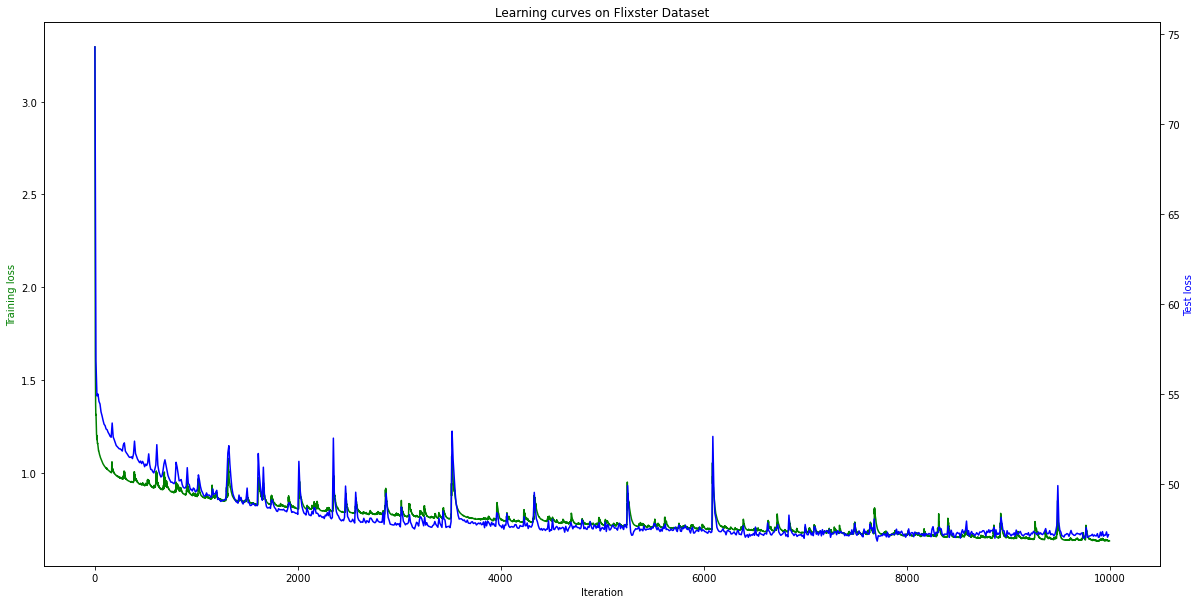

In [29]:
fig, ax1 = plt.subplots(figsize=(20,10))
plt.title('Learning curves on Flixster Dataset')
ax2 = ax1.twinx()
ax1.plot(np.arange(len(list_training_loss)), list_training_loss, 'g-')
ax2.plot(np.arange(len(list_test_pred_error))*num_iter_test, list_test_pred_error, 'b-')

ax1.set_xlabel('Iteration')
ax1.set_ylabel('Training loss', color='g')
ax2.set_ylabel('Test loss', color='b')

best_iter = (np.where(np.asarray(list_training_loss)==np.min(list_training_loss))[0][0]//num_iter_test)*num_iter_test
best_pred_error = list_test_pred_error[best_iter//num_iter_test]
print ('Best predictions at iter: %d (error: %f)' % (best_iter, best_pred_error))
RMSE = np.sqrt(np.square(best_pred_error)/np.sum(Otest))
print ('RMSE: %f' % RMSE)

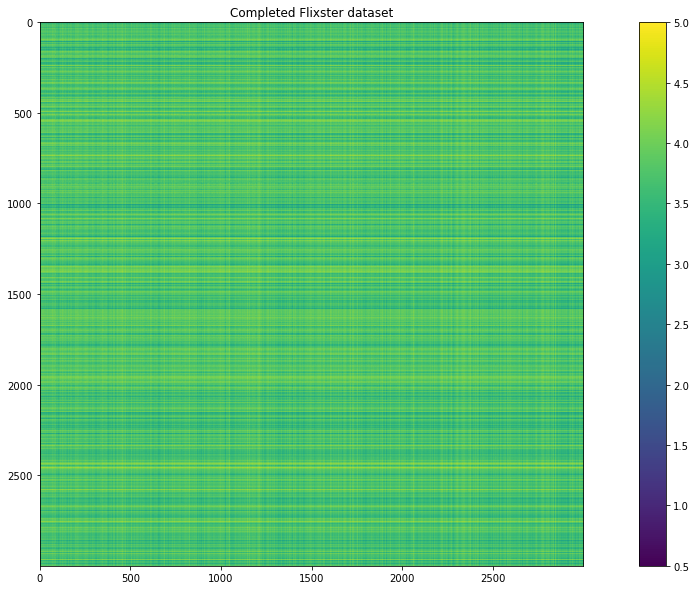

In [30]:
#last X generated
plt.figure(figsize=(20,10))
plt.imshow(X)
plt.title('Completed Flixster dataset')
plt.colorbar()